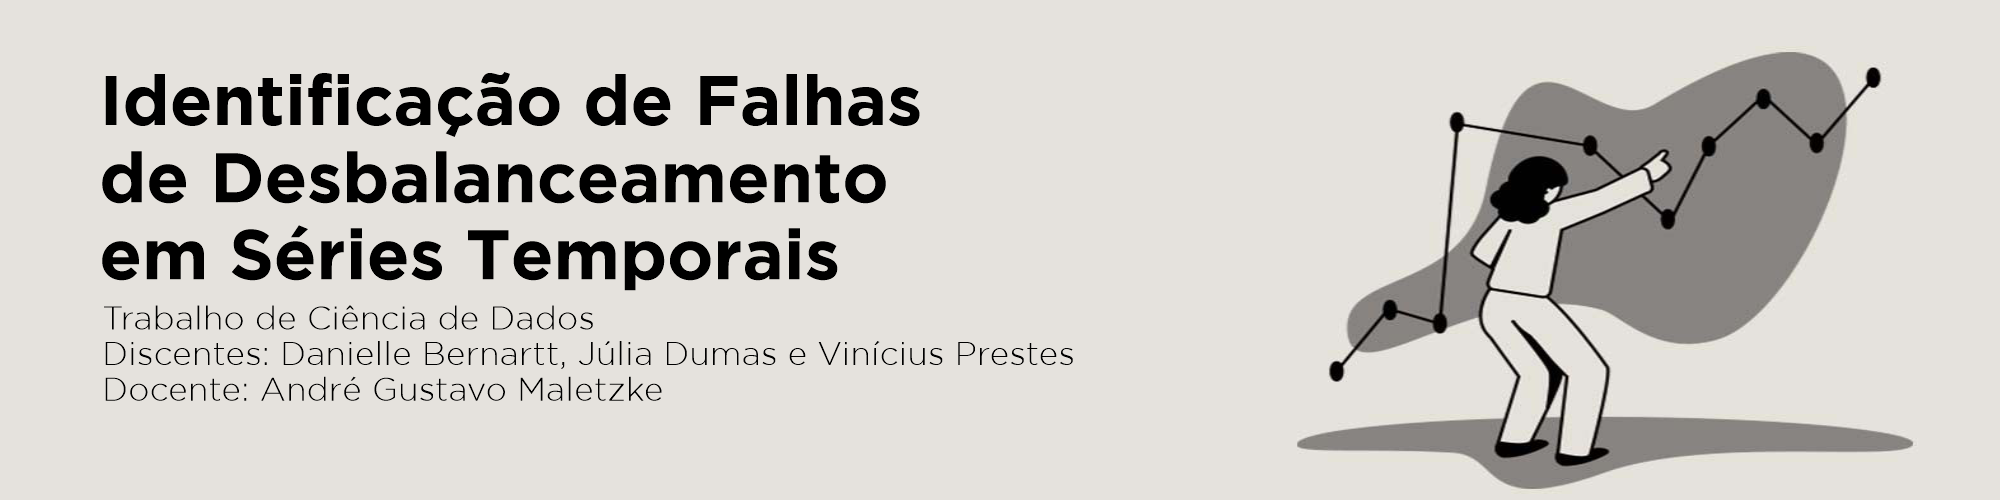

## Introdução

No presente utilizamos os dados encontrados no dataset [**MAFAULDA**](https://https://www02.smt.ufrj.br/~offshore/mfs/page_01.html) (Machinery Fault Database), o mesmo é composto de 1951 séries temporais multivariadas adquiridas por sensores em um Simulador de Falhas de Máquinas (MFS) Alinhamento-Balanço-Vibração (ABVT) da SpectraQuest. Dentro das 1951 séries compreende-se seis diferentes estados simulados: função normal, **falha de desbalanceamento**, falhas de desalinhamento horizontal e vertical e falhas de rolamento interno e externo.

Em nossa abordagem, utilizamos os sinais de estado normal e desbalanceamento de 6g, adquiridos pelo acelerôemtro triaxial IMI na direção tangencial, as especificações do acelerômetro são:
* Sensibility (±20%) 100 mV per g (10.2 mV per m/s2);
* Frequency range (±3 dB) 30-300000 CPM (0.5-5.000 Hz);
* Measurement range ±50 g (±490 m/s2)

## Objetivo

O trabalho consiste em diferenciar, sinais normais de sinais com falha de desbalanceamento por masssa de 6g.

## Desenvolvimento

Durante o desenvolvimento do algoritmo de classificação passamos pelas seguintes etapas:

1. **Análise Exploratória e Carregamento de dados**

  Inicialmente utilizamos recursos das bibliotecas pandas e numpy para analisar os formatos das tabelas e também o tipo de dados que seriam extraidos. Posteriormente usamos comandos de manipulação para ler, transpor e concatenar os dados dentro de cada arquivo .csv para dentro de uma única tabela. Além disso, atribuimos uma coluna com rótulos 0 e 1 para definir as series de falha e não-falha. Finalmente, concatenamos ambas as tabelas e separamos as series em X e os rótulos em y, com os índices sincronizados.

2. **Baseline**

  Na primeira parte desta etapa utilizamos os dados sem qualquer tratamento para treinar e avaliar um classificador KNN a fim de delimitar um desempenho mínimo, aprofundando um pouco realizamos a Transformada Rápida de Fourier nos dados e repetimos o processo para um classificador KNN. Os resultados obtidos para a métrica de acurácia foram relativamente baixos 50-60% o que apontava para um problema com boa complexidade e espaço para melhora.

3. **Extração de Features**

  Para prosseguir com o trabalho, optamos pela estratégia de extração de features, partindo dos sinais temporais e sinais de frequência. Foram coletados features descritivas (média, variância, máximo, curtose, etc.) e features do formato de onda (área, energia, número de picos, frequência nos picos, etc.) dos sinais no tempo e frequência.
  Ainda nessa etapa foram analisadas as correlações entre as features e o a target e desenvolvido uma Análise de Componentes Principais (PCA) com objetivo de reduzir a dimensionalidade e criar 10 hiperparâmetros para serem utilizados nos classificadores.

4. **Modelagem dos Classificadores**

  Primeiramente otimizamos os parâmetros de execução para três classificadores: KNearestNeighbor, RandomForest e SupportVectorMachines. A otimização foi feita com a variação dos parâmetros pela função GridSearchCV, aplicada aos dados obtidos na etapa anterior.
  Posteriormente com os classificadores otimizados, treinamos e avaliamos a acurácia de cada um deles para as features extraidas inicialmente e depois para os hiperparâmetros obtidos no PCA.

5. **Análise Estatística**

  Finalmente, foi feito um teste estatístico ANOVA nos resultados das métricas de acurácia encontradas na etapa de modelagem. Posteriormento foi feito um pós teste de Tuckey para analisar a semelhança individualmente.

6. **Gráficos dos Resultados**

  Nesta etapa foram plotados alguns gráficos que facilitarão a compreensão e entendimento dos resultados obtidos.



## 1. Análise Exploratória e Carregamento de dados

In [ ]:
import pandas as pd
import os

In [ ]:
x = pd.read_csv('/content/drive/MyDrive/DATASETS/normal/12.288.csv')

In [ ]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249999 entries, 0 to 249998
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   4.5595     249999 non-null  float64
 1   0.1752     249999 non-null  float64
 2   0.28721    249999 non-null  float64
 3   -0.017751  249999 non-null  float64
 4   -0.41565   249999 non-null  float64
 5   0.032459   249999 non-null  float64
 6   -0.11218   249999 non-null  float64
 7   -0.12814   249999 non-null  float64
dtypes: float64(8)
memory usage: 15.3 MB


In [ ]:
# Passo 1: Identificar o diretório com os arquivos .csv
diretorio = '/content/drive/MyDrive/DATASETS/normal'

In [ ]:
# Passo 2: Iniciar o dataframe_normal que será o destino final dos arquivos
df_normal = pd.DataFrame()

In [ ]:
# Passo 3: Listar os arquivos dentro do diretório
arquivos = [arquivo for arquivo in os.listdir(diretorio) if arquivo.endswith('.csv')]

In [ ]:
# Passo 4: Loop pelos arquivos dentro do diretório
for i, arquivo in enumerate(arquivos):

    # Passo 5: Ler o conteúdo de cada arquivo em um DataFrame auxiliar
    caminho_arquivo = os.path.join(diretorio, arquivo)
    dataframe_aux = pd.read_csv(caminho_arquivo, header=None)

    # Passo 6: Selecionar a sétima coluna e transpor o DataFrame auxiliar
    coluna_setima = dataframe_aux.iloc[:, 6].to_frame().T
    # Renomear as colunas para evitar conflitos
    coluna_setima.columns = [str(j) for j in range(len(coluna_setima.columns))]

    # Passo 7: Concatenar o DataFrame auxiliar transposto ao DataFrame dataframe_normal
    df_normal = pd.concat([df_normal, coluna_setima], ignore_index=True)

In [ ]:
# Passo 8: Nomear as colunas do DataFrame normal como '0' até 'n' para cada arquivo
df_normal.columns = [str(i) for i in range(len(df_normal.columns))]

In [ ]:
df_normal

,0,1,2,3,4,5,6,7,8,9,...,249990,249991,249992,249993,249994,249995,249996,249997,249998,249999
0,-0.112180,-0.110430,-0.143310,-0.119840,-0.252700,-0.142580,-0.276110,-0.160860,-0.247530,-0.201080,...,0.078097,-0.055555,0.091114,-0.065470,0.086356,0.033041,0.088866,0.042475,-0.000873,0.120810
1,0.172620,0.213680,0.123850,0.200270,0.134940,0.192930,0.158150,0.168720,0.201270,0.149470,...,0.306730,0.219280,0.281120,0.245280,0.261110,0.263630,0.216960,0.282380,0.203420,0.309120
2,-0.006453,-0.043398,-0.012220,-0.046275,-0.162610,-0.025501,-0.151200,-0.025796,-0.153590,-0.072586,...,-0.447890,-0.325400,-0.435930,-0.365610,-0.489760,-0.414030,-0.429160,-0.412410,-0.343560,-0.391030
3,0.119940,0.144960,0.109920,0.197380,0.162000,0.233890,0.146990,0.192930,0.146480,0.142410,...,0.550570,0.454640,0.511910,0.460870,0.495120,0.447990,0.415070,0.477090,0.422260,0.526910
4,-0.250350,-0.283790,-0.239980,-0.209310,-0.262170,-0.179500,-0.290560,-0.150120,-0.275320,-0.196390,...,0.192210,0.098043,0.165890,0.093240,0.116790,0.068798,0.064585,0.078341,0.049629,0.129980
5,0.117410,0.142380,0.095648,0.080955,0.103240,0.031474,0.154800,-0.068187,0.168930,0.012395,...,-0.041196,-0.052428,-0.059415,0.090189,0.102420,0.292200,0.297010,0.485470,0.477940,0.490520
6,-0.599500,-0.633650,-0.604320,-0.650810,-0.629390,-0.696090,-0.758370,-0.750050,-0.830450,-0.823090,...,0.003032,0.018598,0.048871,0.000527,0.022606,-0.085853,-0.005413,-0.083683,-0.055523,-0.098967
7,-0.123540,-0.109880,-0.120110,-0.171460,-0.134930,-0.204070,-0.151540,-0.232490,-0.219310,-0.214340,...,-0.402430,-0.279900,-0.360180,-0.230530,-0.251560,-0.171840,-0.099185,-0.101640,-0.062234,-0.081570
8,0.559980,0.568860,0.598870,0.627050,0.612340,0.672020,0.612110,0.613890,0.522480,0.509180,...,-0.062696,-0.065329,-0.089154,-0.068463,-0.126090,-0.047797,-0.135230,-0.066620,-0.129010,-0.067712
9,0.421060,0.287920,0.483370,0.243200,0.459190,0.232590,0.348340,0.292430,0.303780,0.337630,...,-1.000400,-1.206300,-1.247100,-1.372200,-1.528200,-1.551500,-1.726900,-1.649000,-1.782000,-1.610600


In [ ]:
# Repetindo as etapas para os dados de falha
diretorio2 = '/content/drive/MyDrive/DATASETS/imbalance/6g'

In [ ]:
# Passo 2: Iniciar o dataframe_normal que será o destino final dos arquivos
df_imb6 = pd.DataFrame()

In [ ]:
# Passo 3: Listar os arquivos dentro do diretório
arquivos = [arquivo for arquivo in os.listdir(diretorio2) if arquivo.endswith('.csv')]

In [ ]:
# Passo 4: Loop pelos arquivos dentro do diretório
for i, arquivo in enumerate(arquivos):

    # Passo 5: Ler o conteúdo de cada arquivo em um DataFrame auxiliar
    caminho_arquivo = os.path.join(diretorio2, arquivo)
    dataframe_aux = pd.read_csv(caminho_arquivo, header=None)

    # Passo 6: Selecionar a sétima coluna e transpor o DataFrame auxiliar
    coluna_setima = dataframe_aux.iloc[:, 6].to_frame().T
    # Renomear as colunas para evitar conflitos
    coluna_setima.columns = [str(j) for j in range(len(coluna_setima.columns))]

    # Passo 7: Concatenar o DataFrame auxiliar transposto ao DataFrame dataframe_normal
    df_imb6 = pd.concat([df_imb6, coluna_setima], ignore_index=True)

In [ ]:
# Passo 8: Nomear as colunas do DataFrame normal como '0' até 'n' para cada arquivo
df_imb6.columns = [str(i) for i in range(len(df_imb6.columns))]

In [ ]:
df_imb6

,0,1,2,3,4,5,6,7,8,9,...,249990,249991,249992,249993,249994,249995,249996,249997,249998,249999
0,-0.184470,-0.287120,-0.212150,-0.300760,-0.241470,-0.278570,-0.262540,-0.215090,-0.251330,-0.180340,...,0.224300,0.165190,0.240200,0.168280,0.237440,0.174910,0.207990,0.204830,0.206500,0.247670
1,-0.458800,-0.429410,-0.490330,-0.402510,-0.549930,-0.406770,-0.551700,-0.407100,-0.386240,-0.396450,...,-0.088127,-0.064225,-0.077267,-0.079560,-0.071057,-0.094285,-0.071340,-0.191720,-0.088262,-0.156400
2,-0.141820,0.007957,-0.197930,0.020217,-0.197230,-0.040155,-0.083747,-0.050135,0.008400,-0.097079,...,-0.859370,-0.808890,-0.890550,-0.798380,-0.889710,-0.823220,-0.850720,-0.857650,-0.837480,-0.923910
3,-0.373110,-0.472410,-0.482930,-0.532250,-0.590790,-0.589410,-0.657820,-0.569740,-0.599100,-0.521980,...,0.861280,0.980230,0.892720,0.953760,0.923340,0.921670,0.918390,0.827250,0.893390,0.815780
4,-0.130540,-0.071777,-0.126310,-0.093990,-0.148580,-0.143120,-0.150170,-0.179750,-0.157480,-0.229500,...,1.516100,1.590500,1.531300,1.581200,1.497600,1.528700,1.506000,1.483300,1.535500,1.451700
5,0.518460,0.566880,0.433820,0.501720,0.516040,0.556440,0.552770,0.480990,0.647780,0.561000,...,0.771500,0.660390,0.833230,0.691460,0.836190,0.703220,0.773590,0.696320,0.701480,0.791300
6,-0.635580,-0.612340,-0.460080,-0.557090,-0.373570,-0.522920,-0.403650,-0.490660,-0.418900,-0.465290,...,0.629000,0.736180,0.635040,0.742120,0.657610,0.698500,0.653210,0.610850,0.645000,0.509560
7,-0.415050,-0.464720,-0.386130,-0.432410,-0.381360,-0.388940,-0.328510,-0.236630,-0.224370,-0.193990,...,-0.325290,-0.441020,-0.352210,-0.556060,-0.515770,-0.432130,-0.498310,-0.354970,-0.470300,-0.347110
8,-0.103890,-0.056204,-0.037298,-0.089662,0.034274,-0.049814,0.044639,-0.057360,-0.046417,-0.102490,...,0.094017,-0.018276,0.032142,-0.037362,-0.046365,-0.000789,-0.101370,0.015175,-0.099590,0.054323
9,-0.144630,-0.115570,0.041300,-0.019387,0.094839,-0.083805,0.001548,-0.099667,-0.109860,-0.174010,...,0.317400,0.286700,0.418910,0.413580,0.470270,0.547460,0.535520,0.590490,0.507260,0.552920


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
data_norm= np.array(df_normal)

In [ ]:
data_imb= np.array(df_imb6)

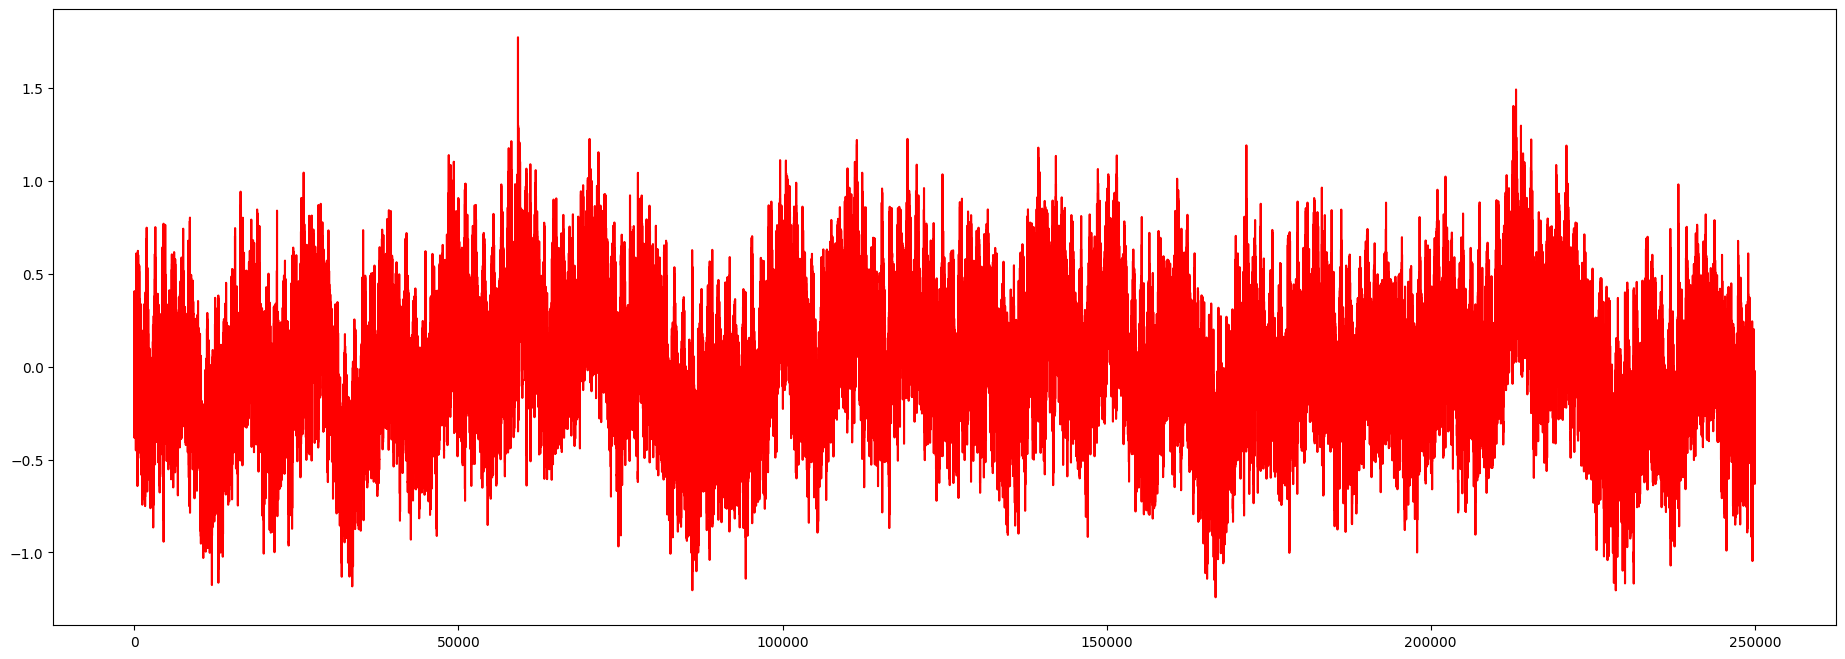

In [ ]:
plt.figure(figsize=(23, 8))
plt.plot(data_norm[34,:], color ="red")

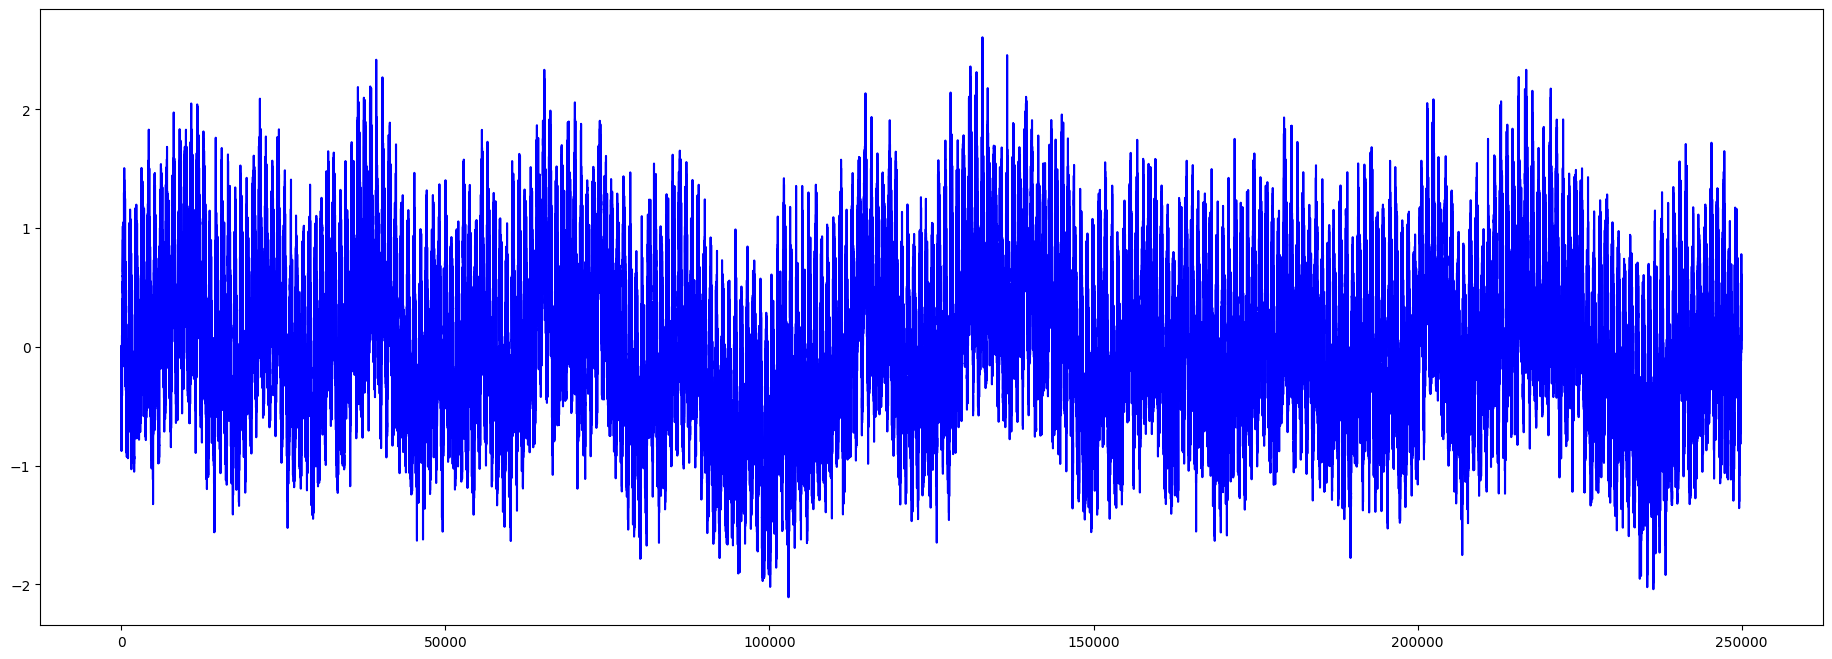

In [ ]:
plt.figure(figsize=(23, 8))
plt.plot(data_imb[40,:], color ="blue")

In [ ]:
df_normal['target'] = 0

In [ ]:
df_imb6['target'] = 1

In [ ]:
sinais_tempo = pd.concat([df_normal, df_imb6], axis = 0)

In [ ]:
sinais_tempo.head()

,0,1,2,3,4,5,6,7,8,9,...,249991,249992,249993,249994,249995,249996,249997,249998,249999,target
0,-0.112180,-0.110430,-0.14331,-0.119840,-0.25270,-0.142580,-0.27611,-0.160860,-0.24753,-0.201080,...,-0.055555,0.091114,-0.06547,0.086356,0.033041,0.088866,0.042475,-0.000873,0.12081,0
1,0.172620,0.213680,0.12385,0.200270,0.13494,0.192930,0.15815,0.168720,0.20127,0.149470,...,0.219280,0.281120,0.24528,0.261110,0.263630,0.216960,0.282380,0.203420,0.30912,0
2,-0.006453,-0.043398,-0.01222,-0.046275,-0.16261,-0.025501,-0.15120,-0.025796,-0.15359,-0.072586,...,-0.325400,-0.435930,-0.36561,-0.489760,-0.414030,-0.429160,-0.412410,-0.343560,-0.39103,0
3,0.119940,0.144960,0.10992,0.197380,0.16200,0.233890,0.14699,0.192930,0.14648,0.142410,...,0.454640,0.511910,0.46087,0.495120,0.447990,0.415070,0.477090,0.422260,0.52691,0
4,-0.250350,-0.283790,-0.23998,-0.209310,-0.26217,-0.179500,-0.29056,-0.150120,-0.27532,-0.196390,...,0.098043,0.165890,0.09324,0.116790,0.068798,0.064585,0.078341,0.049629,0.12998,0


In [ ]:
X = sinais_tempo.drop('target', axis = 1)
y = sinais_tempo['target']

# 2. Baseline

## Baseline 1 - Raw Data

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3)

In [ ]:
resultados= []

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
for k in range(1, 21, 2):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  acuracia = accuracy_score(y_test, y_pred)
  resultados.append((k, acuracia))

In [ ]:
resultados

[(1, 0.6666666666666666),
 (3, 0.6),
 (5, 0.6),
 (7, 0.6),
 (9, 0.6),
 (11, 0.6),
 (13, 0.6),
 (15, 0.6),
 (17, 0.6),
 (19, 0.6)]

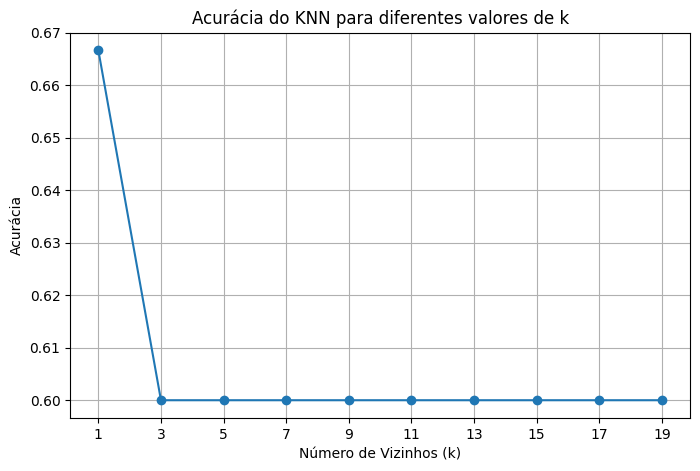

In [ ]:
import matplotlib.pyplot as plt

# Extrai os valores de k e acuracia para o plot
valores_k = [k for k, _ in resultados]
valores_acuracia = [acuracia for _, acuracia in resultados]

# Plot dos resultados
plt.figure(figsize=(8, 5))
plt.plot(valores_k, valores_acuracia, marker='o', linestyle='-')
plt.title('Acurácia do KNN para diferentes valores de k')
plt.xlabel('Número de Vizinhos (k)')
plt.ylabel('Acurácia')
plt.xticks(valores_k)
plt.grid(True)
plt.show()

## Baseline 2 - FFT

In [ ]:
def calcular_fft(dataframe, frequencia_amostragem):
    # Obtém os valores de tempo das colunas do DataFrame
    tempos = dataframe.columns.astype(float).values

    # Calcula as frequências correspondentes
    frequencias = np.fft.fftfreq(len(tempos), d=1.0/frequencia_amostragem)

    # Lista para armazenar os resultados da FFT para cada linha
    resultados_fft = []

    # Itera sobre as linhas do DataFrame
    for _, linha in dataframe.iterrows():
        sinal_temporal = linha.values.astype(float)

        # Aplica a FFT no sinal
        fft_result = np.fft.fft(sinal_temporal)

        # Armazena apenas os valores reais da transformada
        fft_result_real = np.abs(fft_result)

        resultados_fft.append(fft_result_real)

    # Cria um novo DataFrame com os resultados da FFT
    df_fft = pd.DataFrame(resultados_fft, columns=frequencias)

    return df_fft

In [ ]:
resultado_fft = calcular_fft(X,5000)

In [ ]:
espectro_freq= np.array(resultado_fft)

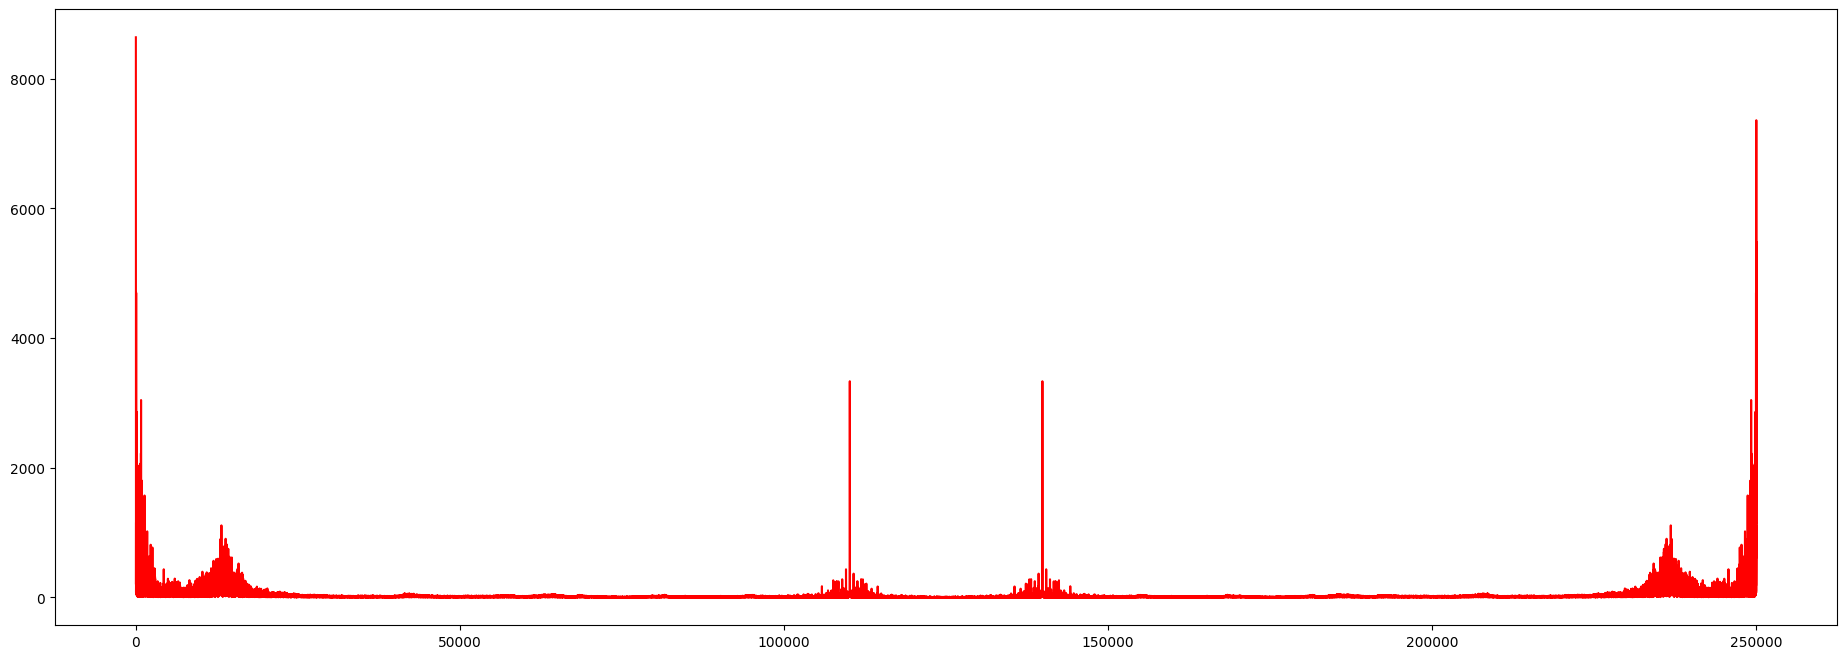

In [ ]:
plt.figure(figsize=(23, 8))
plt.plot(espectro_freq[7,:], color ="red")

In [ ]:
X_train, X_test, y_train, y_test =  train_test_split(resultado_fft, y, test_size=0.3)

In [ ]:
resultados2= []

In [ ]:
for k in range(1, 21, 2):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  acuracia = accuracy_score(y_test, y_pred)
  resultados2.append((k, acuracia))

In [ ]:
resultados2

[(1, 0.5333333333333333),
 (3, 0.5666666666666667),
 (5, 0.5666666666666667),
 (7, 0.5333333333333333),
 (9, 0.5),
 (11, 0.5),
 (13, 0.5),
 (15, 0.5333333333333333),
 (17, 0.5333333333333333),
 (19, 0.5333333333333333)]

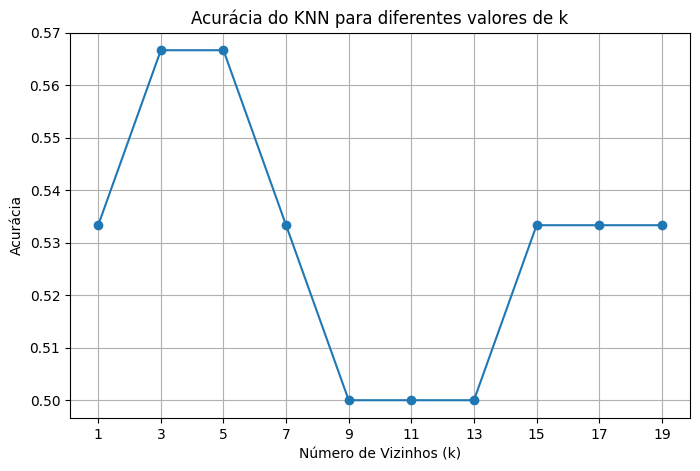

In [ ]:
import matplotlib.pyplot as plt

# Extrai os valores de k e acuracia para o plot
valores_k = [k for k, _ in resultados2]
valores_acuracia = [acuracia for _, acuracia in resultados2]

# Plot dos resultados
plt.figure(figsize=(8, 5))
plt.plot(valores_k, valores_acuracia, marker='o', linestyle='-')
plt.title('Acurácia do KNN para diferentes valores de k')
plt.xlabel('Número de Vizinhos (k)')
plt.ylabel('Acurácia')
plt.xticks(valores_k)
plt.grid(True)
plt.show()

# Extração de Features

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

# Coletando estatísticas descritas sobre as séries temporais

# Lista para armazenar as estatísticas descritivas
estatisticas = []
series_temporais = sinais_tempo.drop('target', axis = 1)

# Itera sobre as linhas do DataFrame
for idx, row in series_temporais.iterrows():
    estatisticas_temporais = {
        'Media': np.mean(row),
        'Mediana': np.median(row),
        'Variancia': np.var(row),
        'Desvio Padrao': np.std(row),
        'Minimo': np.min(row),
        'Maximo': np.max(row),
        'Amplitude': np.max(row) - np.min(row),
        'Assimetria': skew(row),
        'Curtose': kurtosis(row)
    }
    estatisticas.append(estatisticas_temporais)

In [ ]:
# Criando um novo DataFrame com as estatísticas descritivas
estatisticas_descritivas = pd.DataFrame(estatisticas)

# Visualizando as estatísticas descritivas
estatisticas_descritivas.head()

,Media,Mediana,Variancia,Desvio Padrao,Minimo,Maximo,Amplitude,Assimetria,Curtose
0,0.004970,0.004688,0.039011,0.197512,-0.79059,0.65547,1.44606,-0.051334,-0.250981
1,-0.000381,-0.014455,0.080805,0.284262,-0.81964,0.87314,1.69278,0.178161,-0.583970
2,0.072061,0.067604,0.045583,0.213502,-0.75739,0.96411,1.72150,0.148344,-0.123677
3,-0.007971,-0.006884,0.085261,0.291994,-1.09950,1.07380,2.17330,0.016333,-0.187627
4,-0.014068,-0.014969,0.062565,0.250130,-0.97276,0.98149,1.95425,0.060363,-0.025296


In [ ]:
 #Calculando área sob a curva e a energia dos sinais temporais
estatisticas = []

for idx, row in series_temporais.iterrows():
    estatisticas_waveform = {
        'Area': np.trapz(row, dx=1),
        'Energia': np.sum(np.square(row)),
    }
    estatisticas.append(estatisticas_waveform)

In [ ]:
estatisticas_waveform = pd.DataFrame(estatisticas)
estatisticas_waveform.head()

,Area,Energia
0,1242.505122,9758.967932
1,-95.436699,20201.207507
2,18015.423943,12693.942740
3,-1993.041931,21331.049125
4,-3516.981324,15690.778392


In [ ]:
from collections import Counter
from scipy.stats import entropy

# Lista para armazenar a entropia de cada sinal
entropias = []

# Itera sobre as linhas do DataFrame
for idx, row in series_temporais.iterrows():
    # Conta a frequência dos valores na série temporal
    counts = np.array(list(Counter(row).values()))

    # Calcula a distribuição de probabilidade normalizada
    probabilidade = counts / np.sum(counts)

    # Calcula a entropia de Shannon com a distribuição de probabilidade
    entropia = entropy(probabilidade)
    entropias.append(entropia)

# Adiciona a lista de entropias como uma nova coluna no DataFrame original
estatisticas_waveform['Entropia'] = entropias

# Visualiza o DataFrame com a nova coluna
estatisticas_waveform.head()


,Area,Energia,Entropia
0,1242.505122,9758.967932,11.183119
1,-95.436699,20201.207507,11.390573
2,18015.423943,12693.942740,11.223850
3,-1993.041931,21331.049125,11.414787
4,-3516.981324,15690.778392,11.328667


In [ ]:
# Estatisticas descritivas dos sinais no domínio da frequência

estatisticas3 = []

# Itera sobre as linhas do DataFrame
for idx, row in resultado_fft.iterrows():
  estatisticas_fft = {
      'MediaFFT': np.mean(row),
      'VarianciaFFT': np.var(row),
      'Desvio PadraoFFT': np.std(row),
      'AssimetriaFFT': skew(row),
      'CurtoseFFT': kurtosis(row),
  }
  estatisticas3.append(estatisticas_fft)

In [ ]:
estatisticas_FFT = pd.DataFrame(estatisticas3)
estatisticas_FFT.head(20)

,MediaFFT,VarianciaFFT,Desvio PadraoFFT,AssimetriaFFT,CurtoseFFT
0,13.431323,9578.567494,97.870156,63.293917,5606.392760
1,14.556625,19989.312177,141.383564,105.130068,14243.356599
2,23.796510,12127.668846,110.125696,62.324118,6564.545448
3,25.316349,20690.131616,143.840647,75.439057,7910.986768
4,25.964045,15016.646756,122.542428,68.842977,8042.900326
5,27.205734,21414.033676,146.335347,90.543759,12302.298124
6,28.575038,21617.399856,147.028568,75.007739,8980.633345
7,25.465974,6090.386824,78.040930,30.220786,2081.652361
8,32.162090,29983.371696,173.157072,116.760962,23236.313854
9,35.338906,85762.806739,292.852876,134.563540,24508.709031


In [ ]:
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

# Amplitude média, n de picos e frequencia nos picos

# Lista para armazenar os resultados
resultados4 = []

# Parâmetros para encontrar os picos
altura = 4000  # Ajuste conforme necessário
distancia = 10000  # Ajuste conforme necessário

# Frequências associadas aos coeficientes da FFT
frequencias = fftfreq(len(resultado_fft.columns))

# Itera sobre as linhas do DataFrame
for idx, row in resultado_fft.iterrows():
    # Encontra os picos nos coeficientes da FFT
    picos, _ = find_peaks(np.abs(row), height=altura, distance=distancia)

    # Obtém as frequências dos picos
    frequencias_picos = frequencias[picos]

    # Calcula a amplitude média do sinal em frequência
    amplitude_media = np.mean(np.abs(row))

    # Adiciona os resultados à lista
    resultado = {
        'Amplitude_Media': amplitude_media,
        'Numero_Picos': len(picos)
    }

    for i, freq in enumerate(frequencias_picos, start=1):
        resultado[f'Frequencia_Pico_{i}'] = freq

    resultados4.append(resultado)

# Cria um DataFrame auxiliar com os resultados
estatisticas_picos = pd.DataFrame(resultados4)

In [ ]:
# Visualiza o DataFrame com as novas colunas
estatisticas_picos = estatisticas_picos.fillna(0)
estatisticas_picos.head()

,Amplitude_Media,Numero_Picos,Frequencia_Pico_1,Frequencia_Pico_2,Frequencia_Pico_3,Frequencia_Pico_4,Frequencia_Pico_5,Frequencia_Pico_6
0,13.431323,4,0.000484,0.440772,-0.440772,-0.000484,0.0,0.0
1,14.556625,4,0.000024,0.440584,-0.440584,-0.000024,0.0,0.0
2,23.796510,4,0.000012,0.440604,-0.440604,-0.000012,0.0,0.0
3,25.316349,4,0.000044,0.440612,-0.440612,-0.000044,0.0,0.0
4,25.964045,4,0.000064,0.440612,-0.440612,-0.000064,0.0,0.0


In [ ]:
# Concatenar ao longo das colunas (axis=1)
features = pd.concat([estatisticas_descritivas, estatisticas_waveform, estatisticas_FFT, estatisticas_picos], axis=1)

# Visualizar o DataFrame resultante
print(features)

       Media   Mediana  Variancia  Desvio Padrao   Minimo   Maximo  Amplitude  \
0   0.004970  0.004688   0.039011       0.197512 -0.79059  0.65547    1.44606   
1  -0.000381 -0.014455   0.080805       0.284262 -0.81964  0.87314    1.69278   
2   0.072061  0.067604   0.045583       0.213502 -0.75739  0.96411    1.72150   
3  -0.007971 -0.006884   0.085261       0.291994 -1.09950  1.07380    2.17330   
4  -0.014068 -0.014969   0.062565       0.250130 -0.97276  0.98149    1.95425   
..       ...       ...        ...            ...      ...      ...        ...   
93  0.052039  0.041877   0.645498       0.803429 -2.73080  3.49450    6.22530   
94  0.017351 -0.012304   1.002964       1.001481 -3.03080  3.34110    6.37190   
95  0.027905  0.327020   2.867640       1.693411 -5.02650  3.97400    9.00050   
96  0.285373  0.625015   2.896455       1.701897 -4.73840  4.44260    9.18100   
97  0.046483  0.043782   0.632912       0.795558 -2.60320  3.95400    6.55720   

    Assimetria   Curtose   

In [ ]:
y.name = 'target'
y.reset_index(drop=True, inplace=True)

In [ ]:
y_df = []

In [ ]:
y_df = pd.DataFrame({'target': y})

# Concatenando 'y_df' com 'features' ao longo das colunas (axis=1)
correlationfeats = pd.concat([y_df, features], axis=1)

# Calculando a matriz de correlação
correlation_matrix = correlationfeats.corr()


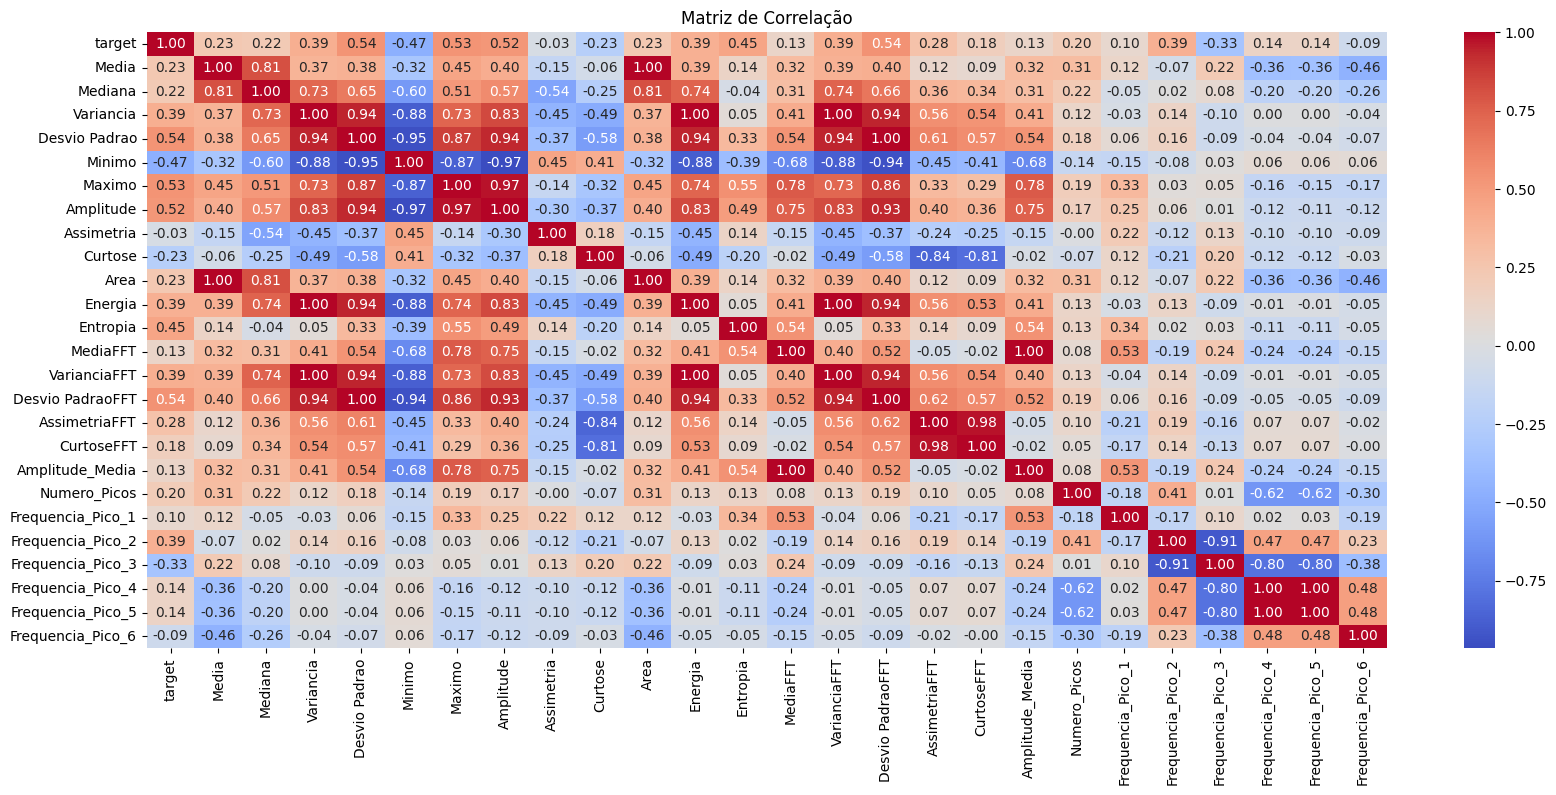

In [ ]:
import seaborn as sns

# Criando o heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(features)

Variância explicada por cada componente principal:
[0.33331082 0.23771227 0.15459043 0.08986975 0.0548975  0.05051838
 0.02895958 0.02090967 0.01336099 0.00576615]


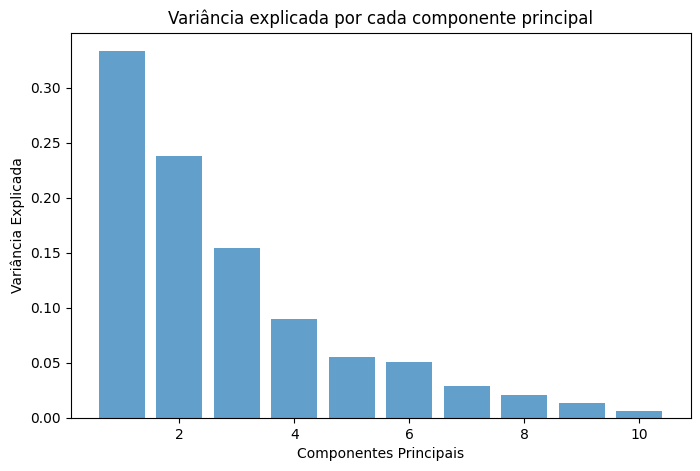

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Supondo que 'features' seja seu DataFrame com as features extraídas

# Inicializando o PCA com o número de componentes desejado
num_components = 10  # Ajuste o número de componentes conforme necessário
pca = PCA(n_components=num_components)

# Aplicando o PCA aos dados
principal_components = pca.fit_transform(X_norm)

# Criando um novo DataFrame com os componentes principais
columns = [f'PC{i+1}' for i in range(num_components)]
X_pca = pd.DataFrame(data=principal_components, columns=columns)

# Verificando a variância explicada por cada componente
explained_variance_ratio = pca.explained_variance_ratio_
print("Variância explicada por cada componente principal:")
print(explained_variance_ratio)

# Explained variance plot
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7)
plt.xlabel('Componentes Principais')
plt.ylabel('Variância Explicada')
plt.title('Variância explicada por cada componente principal')
plt.show()


In [ ]:
X_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-0.970360,-0.097778,-0.103832,-0.012085,0.096895,0.548681,0.335564,-0.108065,0.068476,-0.077493
1,-0.947406,0.076372,0.166245,0.010972,0.272895,0.127110,0.082708,0.032590,-0.076234,-0.077506
2,-0.847731,-0.046907,0.120865,-0.126576,-0.119563,0.405816,0.008661,0.030875,-0.240264,-0.059759
3,-0.744396,0.026757,0.048367,-0.064217,-0.033387,0.069926,0.113987,-0.050773,0.012077,-0.005270
4,-0.806722,-0.032042,0.012325,-0.076539,-0.091119,0.128887,0.192722,-0.014268,-0.061956,0.019055
...,...,...,...,...,...,...,...,...,...,...
93,0.644839,0.371287,-0.016391,-0.109134,-0.331900,-0.274045,-0.109320,0.208445,-0.102672,0.059073
94,0.700550,0.553791,0.137173,0.081378,-0.247603,-0.280486,0.139682,0.251683,-0.140191,0.014913
95,1.544780,1.472207,0.947807,0.795045,-0.230899,0.218442,0.649132,0.168646,-0.015001,0.042231
96,1.818402,1.375979,1.006856,0.441111,-0.670073,0.854293,-0.180366,0.190829,0.119867,-0.125487


# 4. Modelagem dos Classificadores

In [ ]:
X_train, X_test, y_train, y_test =  train_test_split(X_norm, y, test_size=0.3)

In [ ]:
resultados_extracao_knn = []
for k in range(1, 21, 2):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  acuracia = accuracy_score(y_test, y_pred)
  resultados_extracao_knn.append((k, acuracia))

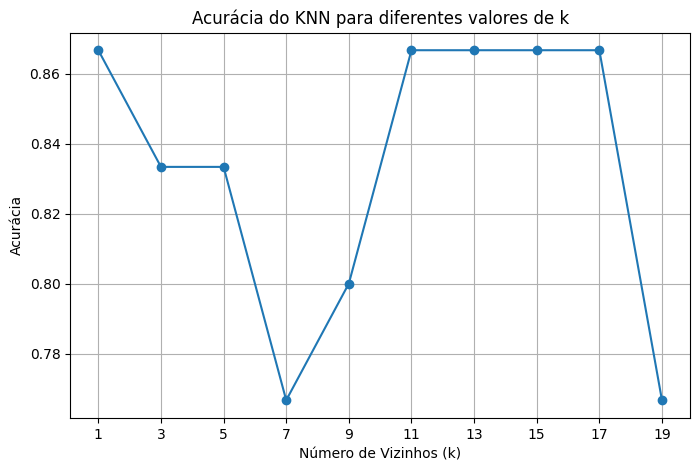

In [ ]:
import matplotlib.pyplot as plt

# Extrai os valores de k e acuracia para o plot
valores_k = [k for k, _ in resultados_extracao_knn]
valores_acuracia = [acuracia for _, acuracia in resultados_extracao_knn]

# Plot dos resultados
plt.figure(figsize=(8, 5))
plt.plot(valores_k, valores_acuracia, marker='o', linestyle='-')
plt.title('Acurácia do KNN para diferentes valores de k')
plt.xlabel('Número de Vizinhos (k)')
plt.ylabel('Acurácia')
plt.xticks(valores_k)
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svm = SVC()

param_grid = {'C': [0.1, 1, 10, 100],
              'kernel': ['linear', 'rbf','sigmoid','poly'],
              'gamma': [0.1, 0.01, 0.001, 0.0001]}

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_norm, y)
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor score:", grid_search.best_score_)
svm_optimal = grid_search.best_estimator_


Melhores parâmetros: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Melhor score: 0.9068421052631578


In [ ]:
# Definindo os parâmetros a serem testados
param_grid = {
    'n_estimators': [1, 10 , 20, 50, 100, 150],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Criando o classificador Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Criando o objeto GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, scoring='accuracy')

# Realizando a busca de grade (Grid Search)
grid_search.fit(X_norm, y)

# Obtendo os melhores parâmetros encontrados
best_params = grid_search.best_params_
best_score = grid_search.best_score_
rf_optimal = grid_search.best_estimator_

print("Melhores parâmetros:", best_params)
print("Melhor score de validação:", best_score)

Melhores parâmetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Melhor score de validação: 0.9166666666666667


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

knn = KNeighborsClassifier(n_neighbors=1)
rf = rf_optimal
svm = svm_optimal

scores_knn = cross_val_score(knn, X_norm, y, cv=10, scoring='accuracy')
scores_rf = cross_val_score(rf, X_norm, y, cv=10, scoring='accuracy')
scores_svm = cross_val_score(svm, X_norm, y, cv=10, scoring='accuracy')

In [ ]:
# Calcular média e desvio padrão das acurácias
media_acuracia_knn = np.mean(scores_knn)
desvio_padrao_acuracia_knn = np.std(scores_knn)

# Armazenar os valores em um dicionário
resultado_knn = {
    'Média_Acurácia': [media_acuracia_knn],
    'Desvio_Padrão_Acurácia': [desvio_padrao_acuracia_knn]
}

# Converter o dicionário em um DataFrame pandas
final_knn = pd.DataFrame(resultado_knn)
final_knn

,Média_Acurácia,Desvio_Padrão_Acurácia
0,0.867778,0.099932


In [ ]:
# Calcular média e desvio padrão das acurácias
media_acuracia_rf = np.mean(scores_rf)
desvio_padrao_acuracia_rf = np.std(scores_rf)

# Armazenar os valores em um dicionário
resultado_rf = {
    'Média_Acurácia': [media_acuracia_rf],
    'Desvio_Padrão_Acurácia': [desvio_padrao_acuracia_rf]
}

# Converter o dicionário em um DataFrame pandas
final_rf = pd.DataFrame(resultado_rf)
final_rf

,Média_Acurácia,Desvio_Padrão_Acurácia
0,0.916667,0.090711


In [ ]:
# Calcular média e desvio padrão das acurácias
media_acuracia_svm = np.mean(scores_svm)
desvio_padrao_acuracia_svm = np.std(scores_svm)

# Armazenar os valores em um dicionário
resultado_svm = {
    'Média_Acurácia': [media_acuracia_svm],
    'Desvio_Padrão_Acurácia': [desvio_padrao_acuracia_svm]
}

# Converter o dicionário em um DataFrame pandas
final_svm = pd.DataFrame(resultado_svm)
final_svm

,Média_Acurácia,Desvio_Padrão_Acurácia
0,0.884444,0.112678


* Testando com PCA

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svm = SVC()

param_grid = {'C': [0.1, 1, 10, 100],
              'kernel': ['linear', 'rbf','sigmoid','poly'],
              'gamma': [0.1, 0.01, 0.001, 0.0001]}

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_pca, y)
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor score:", grid_search.best_score_)
svm_optimal = grid_search.best_estimator_


Melhores parâmetros: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Melhor score: 0.9378947368421052


In [ ]:
# Definindo os parâmetros a serem testados
param_grid = {
    'n_estimators': [1, 10 , 20, 50, 100, 150],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Criando o classificador Random Forest
rf = RandomForestClassifier(random_state=42)

# Criando o objeto GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

# Realizando a busca de grade (Grid Search)
grid_search.fit(X_pca, y)

# Obtendo os melhores parâmetros encontrados
best_params = grid_search.best_params_
best_score = grid_search.best_score_
rf_optimal = grid_search.best_estimator_

print("Melhores parâmetros:", best_params)
print("Melhor score de validação:", best_score)

Melhores parâmetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Melhor score de validação: 0.8773684210526316


In [ ]:
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=1)
rf = rf_optimal
svm = svm_optimal

scores_knn_pca = cross_val_score(knn, X_pca, y, cv=10, scoring='accuracy')
scores_rf_pca = cross_val_score(rf, X_pca, y, cv=10, scoring='accuracy')
scores_svm_pca = cross_val_score(svm, X_pca, y, cv=10, scoring='accuracy')


In [ ]:
# Calcular média e desvio padrão das acurácias
media_acuracia_knn = np.mean(scores_knn_pca)
desvio_padrao_acuracia_knn = np.std(scores_knn_pca)

# Armazenar os valores em um dicionário
resultado_knn = {
    'Média_Acurácia': [media_acuracia_knn],
    'Desvio_Padrão_Acurácia': [desvio_padrao_acuracia_knn]
}

# Converter o dicionário em um DataFrame pandas
final_knn = pd.DataFrame(resultado_knn)
final_knn

,Média_Acurácia,Desvio_Padrão_Acurácia
0,0.897778,0.089553


In [ ]:
# Calcular média e desvio padrão das acurácias
media_acuracia_rf = np.mean(scores_rf_pca)
desvio_padrao_acuracia_rf = np.std(scores_rf_pca)

# Armazenar os valores em um dicionário
resultado_rf = {
    'Média_Acurácia': [media_acuracia_rf],
    'Desvio_Padrão_Acurácia': [desvio_padrao_acuracia_rf]
}

# Converter o dicionário em um DataFrame pandas
final_rf = pd.DataFrame(resultado_rf)
final_rf

,Média_Acurácia,Desvio_Padrão_Acurácia
0,0.883333,0.134463


In [ ]:
# Calcular média e desvio padrão das acurácias
media_acuracia_svm = np.mean(scores_svm_pca)
desvio_padrao_acuracia_svm = np.std(scores_svm_pca)

# Armazenar os valores em um dicionário
resultado_svm = {
    'Média_Acurácia': [media_acuracia_svm],
    'Desvio_Padrão_Acurácia': [desvio_padrao_acuracia_svm]
}

# Converter o dicionário em um DataFrame pandas
final_svm = pd.DataFrame(resultado_svm)
final_svm

,Média_Acurácia,Desvio_Padrão_Acurácia
0,0.958889,0.050442


# 5. Análise Estatística dos Classificadores

In [ ]:
# Criando um dicionário com os arrays e seus respectivos nomes
data = {
    'KNN': scores_knn,
    'KNN_PCA': scores_knn_pca,
    'RF': scores_rf,
    'RF_PCA': scores_rf_pca,
    'SVM': scores_svm,
    'SVM_PCA': scores_svm_pca,
}

# Criando um DataFrame a partir do dicionário
scores = pd.DataFrame(data)

# Adicionando a coluna de índices de 1 a 10
scores['Fold'] = range(1, 11)

# Reordenando as colunas para ter os índices no início
cols = scores.columns.tolist()
cols = cols[-1:] + cols[:-1]
scores = scores[cols]

# Mostrando o DataFrame resultante
print(scores)


   Fold       KNN   KNN_PCA        RF    RF_PCA       SVM   SVM_PCA
0     1  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
1     2  0.700000  0.700000  0.800000  0.800000  0.800000  0.900000
2     3  0.900000  0.900000  1.000000  1.000000  1.000000  1.000000
3     4  1.000000  1.000000  1.000000  1.000000  1.000000  0.900000
4     5  0.800000  0.800000  0.800000  0.900000  0.800000  1.000000
5     6  0.700000  0.700000  1.000000  1.000000  0.900000  1.000000
6     7  0.900000  0.900000  1.000000  1.000000  1.000000  1.000000
7     8  0.900000  0.900000  0.900000  0.800000  0.900000  0.900000
8     9  0.888889  0.888889  0.888889  0.888889  0.666667  0.888889
9    10  0.888889  0.888889  0.777778  0.666667  0.777778  1.000000


In [ ]:
# Teste ANOVA
from scipy.stats import f_oneway

# Considere que df é o DataFrame com os scores dos classificadores
# Selecione apenas as colunas com os scores para o teste ANOVA
scores_columns = scores.columns[:-1]  # Excluindo a coluna de índices

# Realize o teste ANOVA
f_statistic, p_value = f_oneway(*[scores[col] for col in scores_columns])

# Exibindo os resultados
print(f'F-statistic: {f_statistic}')
print(f'p-value: {p_value}')

F-statistic: 23.053319004200635
p-value: 2.6097868943952655e-12


Como o p-valor associado à Estatística-F do teste foi <0.05, é possível afirmar que foi rejeitada a hipótese nula e há diferença estatística entre os classificadores.

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

scores_tuck = scores.drop('Fold',axis=1)

# Reshape dos dados para o formato adequado para a análise de Tukey
df_melted = pd.melt(scores_tuck.reset_index(), id_vars='index', var_name='classificador', value_name='score')

# Execução do teste de Tukey
tukey_results = pairwise_tukeyhsd(df_melted['score'], df_melted['classificador'])

# Impressão dos resultados
print(tukey_results.summary())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
    KNN KNN_PCA      0.0    1.0 -0.1344 0.1344  False
    KNN      RF   0.0489 0.8892 -0.0855 0.1833  False
    KNN  RF_PCA   0.0378 0.9605 -0.0966 0.1722  False
    KNN     SVM   0.0167 0.9991 -0.1177 0.1511  False
    KNN SVM_PCA   0.0911 0.3542 -0.0433 0.2255  False
KNN_PCA      RF   0.0489 0.8892 -0.0855 0.1833  False
KNN_PCA  RF_PCA   0.0378 0.9605 -0.0966 0.1722  False
KNN_PCA     SVM   0.0167 0.9991 -0.1177 0.1511  False
KNN_PCA SVM_PCA   0.0911 0.3542 -0.0433 0.2255  False
     RF  RF_PCA  -0.0111 0.9999 -0.1455 0.1233  False
     RF     SVM  -0.0322 0.9801 -0.1666 0.1022  False
     RF SVM_PCA   0.0422 0.9375 -0.0922 0.1766  False
 RF_PCA     SVM  -0.0211 0.9972 -0.1555 0.1133  False
 RF_PCA SVM_PCA   0.0533 0.8479 -0.0811 0.1877  False
    SVM SVM_PCA   0.0744 0.5786 -0.0599 0.2088  False
----------------------------

Se a variação é baixa e os valores estão concentrados em um intervalo estreito, pode ser que os métodos estatísticos tradicionais para comparação não demonstrem diferenças significativas entre eles, mesmo que haja pequenas variações nos resultados.

Nesses casos, é importante considerar também aspectos práticos e contextuais. A interpretação estatística pura pode ser limitada quando os valores são muito próximos.

# 6. Gráficos dos Resultados

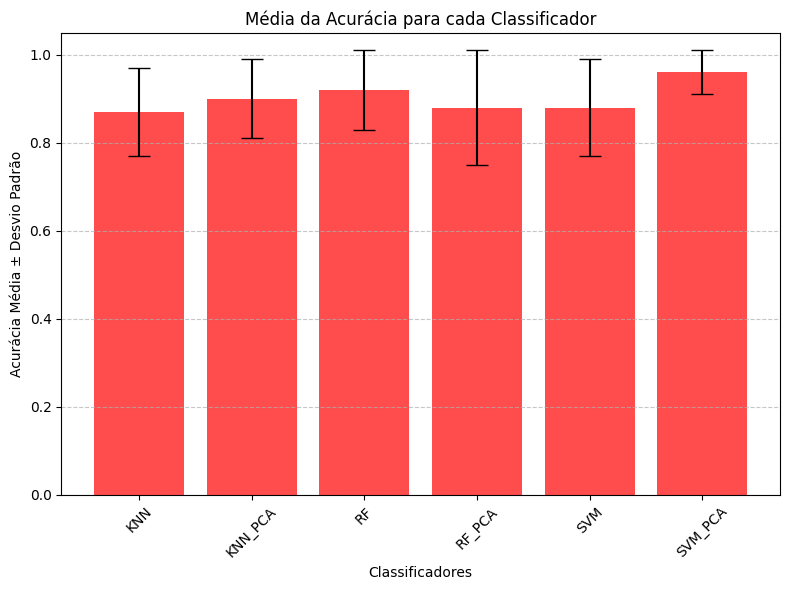

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Médias da acurácia para cada classificador
classificadores = ['KNN', 'KNN_PCA', 'RF', 'RF_PCA', 'SVM', 'SVM_PCA']
medias_acuracia = [0.87, 0.90, 0.92, 0.88, 0.88, 0.96]

# Desvios padrão para cada classificador
desvios_padrao = [0.10, 0.09, 0.09, 0.13, 0.11, 0.05]

# Plotagem do gráfico de barras com barras de erro
plt.figure(figsize=(8, 6))
plt.bar(classificadores, medias_acuracia, yerr=desvios_padrao, capsize=8, color='red', alpha=0.7)
plt.title('Média da Acurácia para cada Classificador')
plt.xlabel('Classificadores')
plt.ylabel('Acurácia Média ± Desvio Padrão')
plt.ylim(0.0, 1.05)  # Definindo o intervalo do eixo y
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

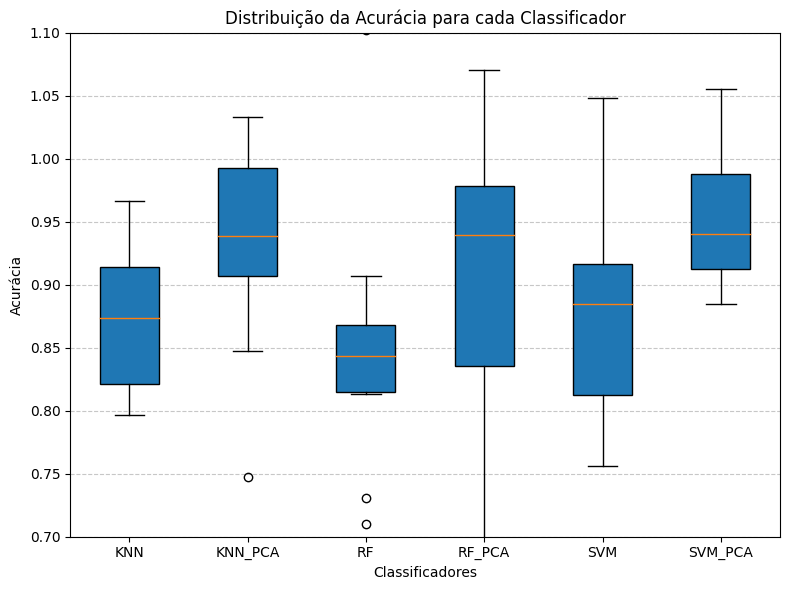

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Dados de acurácia para cada classificador
acuracia_knn = np.random.normal(0.87, 0.10, 10)  # Exemplo: substitua pelos seus valores reais
acuracia_knn_pca = np.random.normal(0.90, 0.09, 10)
acuracia_rf = np.random.normal(0.92, 0.09, 10)
acuracia_rf_pca = np.random.normal(0.88, 0.13, 10)
acuracia_svm = np.random.normal(0.88, 0.11, 10)
acuracia_svm_pca = np.random.normal(0.96, 0.05, 10)

# Agrupando os dados para plotagem
dados_acuracia = [acuracia_knn, acuracia_knn_pca, acuracia_rf, acuracia_rf_pca, acuracia_svm, acuracia_svm_pca]

# Plotando o boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(dados_acuracia, labels=['KNN', 'KNN_PCA', 'RF', 'RF_PCA', 'SVM', 'SVM_PCA'], patch_artist=True)
plt.title('Distribuição da Acurácia para cada Classificador')
plt.xlabel('Classificadores')
plt.ylabel('Acurácia')
plt.ylim(0.7, 1.1)  # Definindo o intervalo do eixo y
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

<ipython-input-117-b74029befb8b>:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(resultados, label=classificador, shade=True)
<ipython-input-117-b74029befb8b>:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(resultados, label=classificador, shade=True)
<ipython-input-117-b74029befb8b>:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(resultados, label=classificador, shade=True)
<ipython-input-117-b74029befb8b>:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(resultados, label=classificador, shade=Tr

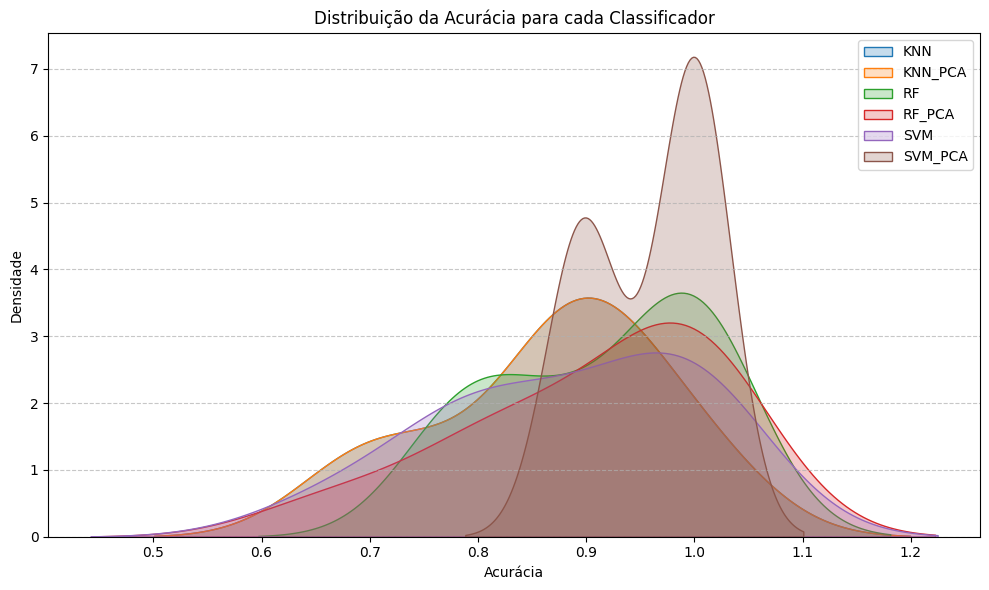

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Criando um gráfico de densidade para cada classificador
plt.figure(figsize=(10, 6))

for classificador, resultados in data.items():
    sns.kdeplot(resultados, label=classificador, shade=True)

plt.title('Distribuição da Acurácia para cada Classificador')
plt.xlabel('Acurácia')
plt.ylabel('Densidade')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()
